# Phylogenetic tree of the Sars-Cov-2 sequencing data

## Software requirements
- R packages (`adegenet`, `ape`, `ggtree`, `magrittr`)
- other softwares: samtools, mafft

## Downloading the data

We downloaded the raw sequencing data and the associated metadata of 733 isolates (all the ones available on Mar 17) from the [GISAID](https://www.gisaid.org/) web site. This data set includes:
- 98 isolates from the US 
- 635 isolates from other countries/sources

**NOTES**: 
- we cannot include the sequence data files (i.e. original fasta and alignments) in this github repository. But you can register on the GISAID website and download the sequences.
- AISC610 students: you can get these files from Canvas. They should be placed in the current working directory. This means that once you unzipped the package you should copy the folders `data` and `out` in the same directory where this Jupyter Notebook is located.


## Generating a sequence alignment

We use [MAFFT](https://mafft.cbrc.jp/alignment/software/) to align all sequences. 

**NOTE**: The code is commented because it takes 2-3 hours to align the sequences with a laptop. We provided the `.fasta` file with the aligned sequences (it is available on `data/gisaid_cov2020_sequences_filtered.fasta`).

In [32]:
#system("mafft --auto data/gisaid_cov2020_sequences_filtered.fasta > data/gisaid_cov2020_sequences_filtered_ali.fasta")

## Phylogenetic tree reconstruction
We load the alignment (converting it to `DNAbin` format, which is suitable to perform fast caculations. The `adegenet` provides a function to do this) and calculate a distance matrix (using the `ape` package):

In [33]:
# we load the alignment
library(adegenet)
library(ape)
ali_reloaded = fasta2DNAbin(file="data/gisaid_cov2020_sequences_filtered_ali.fasta")

# we calculate the distance between the sequences
d_mat = dist.dna(ali_reloaded)


 Converting FASTA alignment into a DNAbin object... 


 Finding the size of a single genome... 


 genome size is: 35,024 nucleotides 

( 585  lines per genome )

 Importing sequences... 
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

We generate a tree using the [BIONJ](http://www.atgc-montpellier.fr/bionj/) algorithm:

In [34]:
tree = bionj(d_mat)

Now we load the strain annotation table (downloaded from the nextstrain [ncov github repository](https://github.com/nextstrain/ncov/tree/master/data)) and we check how it looks like:

In [35]:
tab = read.csv("data/metadata/metadata_cov2020.tsv",sep="\t",stringsAsFactors=FALSE)
head(tab,2)

,strain,virus,gisaid_epi_isl,genbank_accession,date,region,country,division,division_exposure,location,⋯,length,host,age,sex,originating_lab,submitting_lab,authors,url,title,date_submitted
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Anhui/SZ005/2020,ncov,EPI_ISL_413485,?,2020-01-24,Asia,China,Anhui,Anhui,Suzhou,⋯,29860,Human,58,Male,"Department of microbiology laboratory,Anhui Provincial Center for Disease Control and Prevention","Department of microbiology laboratory,Anhui Provincial Center for Disease Control and Prevention",Li et al,https://www.gisaid.org,?,2020-03-05
2,Australia/NSW01/2020,ncov,EPI_ISL_407893,?,2020-01-24,Oceania,Australia,New South Wales,Hubei,Sydney,⋯,29782,Human,43,Male,Centre for Infectious Diseases and Microbiology Laboratory Services,NSW Health Pathology - Institute of Clinical Pathology and Medical Research; Westmead Hospital; University of Sydney,Eden et al,https://www.gisaid.org,?,2020-02-06


The name of the strains in our tree are different compared to the metadata table. For instance, let's determine how the isolate "Anhui/SZ005/2020" is called in our tree:

In [36]:
grep("Anhui/SZ005/2020", tree$tip.label, value = TRUE)

[1] "hCoV-19/Anhui/SZ005/2020|EPI_ISL_413485|2020-01-24"

It is very important (and useful) to have the same IDs in the tree and in the metadata table, so we use the `gsub` function to reformat the strain names in the tree:

In [37]:
library(magrittr)
tree$tip.label = tree$tip %>% 
gsub(pattern = " ", replacement = "") %>% 
gsub(pattern = "hCoV\\-19\\/", replacement = "") %>% 
gsub(pattern = "\\|[A-Z0-9_\\-]+", replacement = "",perl = TRUE) %>%
gsub(pattern = "hCov-19/Netherlands", replacement = "Netherlands",perl = TRUE)
tree$tip=tree$tip.label

The first Sars-Cov-2 complete genome is the one of the isolate "Wuhan-Hu-1" ([NCBI](https://www.ncbi.nlm.nih.gov/nuccore/MN908947))! We search for the ID of this isolate and we root the tree:

In [38]:
tab[grep("Wuhan-Hu-1",tab$strain),]
rtree=root(tree,outgroup="Wuhan-Hu-1/2019")

,strain,virus,gisaid_epi_isl,genbank_accession,date,region,country,division,division_exposure,location,⋯,length,host,age,sex,originating_lab,submitting_lab,authors,url,title,date_submitted
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
746,Wuhan-Hu-1/2019,ncov,EPI_ISL_402125,MN908947,2019-12-26,Asia,China,Hubei,Hubei,Wuhan,⋯,29903,Human,?,?,unknown,National Institute for Communicable Disease Control and Prevention (ICDC) Chinese Center for Disease Control and Prevention (China CDC),Zhang et al,https://www.gisaid.org,?,2020-01-12


We create different categories for the isolates ("USA", "other_countries") and we display the tree using the `ggtree` package:

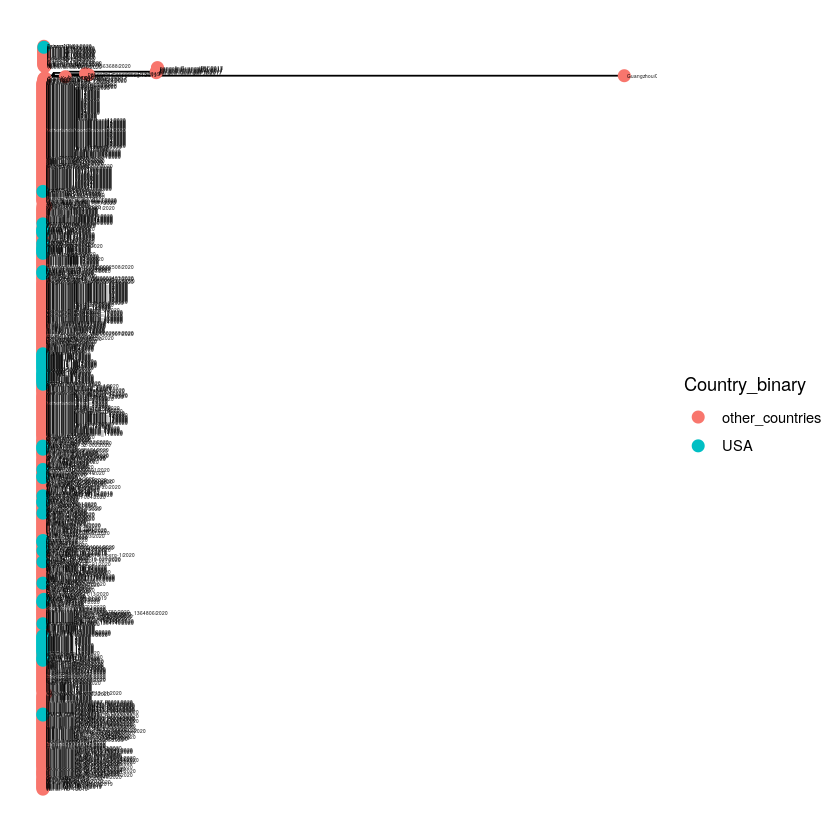

In [39]:
tab$Country_binary = ifelse(tab$country == "USA","USA","other_countries")
md_sel=tab[,c("strain","Country_binary")]

# displaying tree
library(ggtree)
g=ggtree(rtree) 
g %<+% md_sel + geom_tippoint(aes(color=Country_binary), size=3) + geom_tiplab(size=1)
g_final = g %<+% md_sel + geom_tippoint(aes(color=Country_binary), size=3) + geom_tiplab(size=2)

# generating a pdf
ggsave("out/tree_all_isolates.pdf",g_final, height = 70 , width = 30, limitsize=FALSE)

Although the image in the notebook will be a bit difficult to read, we generated a pdf file  (`out/tree_all_isolates.pdf`) that you can donwload and open with your favorite pdf viewer.

Some of the isolates sampled in non-human hosts are so distant from the human strains that we cannot appreciate the differences between them. Let's work with a smaller dataset of 141 human strains (including 78 US isolates). 


 Converting FASTA alignment into a DNAbin object... 


 Finding the size of a single genome... 


 genome size is: 29,980 nucleotides 

( 501  lines per genome )

 Importing sequences... 
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

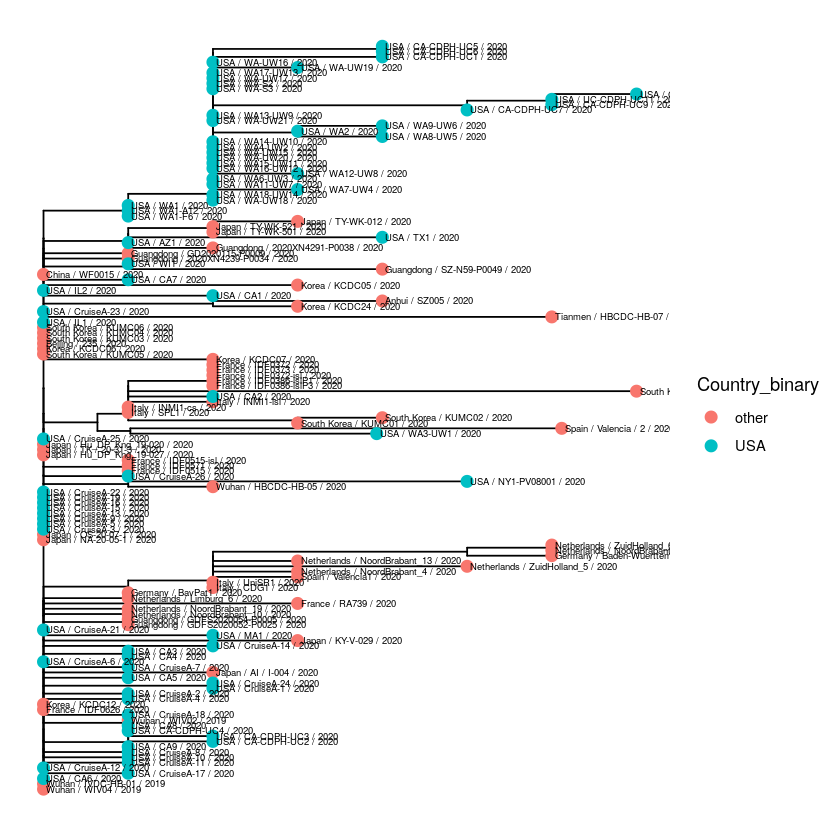

In [40]:
# we load the sequence alignments
ali = fasta2DNAbin(file="data/sars_cov2_ali.fasta")

# we calculate the distance between the sequences
d_mat = dist.dna(ali)

# we calculate the tree and root it
tree = bionj(d_mat)
rtree=root(tree, outgroup="hCoV-19/Wuhan/WIV04/2019|EPI_ISL_402124")

# we reformat the IDs to match the ones in the metadata table
library(magrittr)
rtree$tip.label = rtree$tip %>% 
gsub(pattern = "^ ", replacement = "") %>% 
gsub(pattern = "hCoV-19/", replacement = "") %>% 
gsub(pattern = "\\|[A-Z0-9_\\-]+", replacement = "",perl = TRUE) %>%
gsub(pattern = "\\/", replacement = " \\/ ",perl = TRUE)

# we load the metadata and create a new column: "USA" / "other_countries" 
md = read.csv("data/metadata/geo_loc.tsv",sep="\t")
md$Country_binary = ifelse(md$Country == "USA","USA","other")
md_sel=md[,c("Isolate_short_name","Country_binary")]

# displaying tree
library(ggtree)
g=ggtree(rtree) 
g %<+% md_sel + geom_tippoint(aes(color=Country_binary), size=3) + geom_tiplab(size=2)
g_final = g %<+% md_sel + geom_tippoint(aes(color=Country_binary), size=3) + geom_tiplab(size=3)
ggsave("out/tree_us_vs_other_isolates.pdf",g_final, height = 20 , width = 30)

## Questions
- Can you list one or more examples of community spread?